In [53]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



In [3]:
pokemon_df = pd.read_csv("pokemon.csv")
pokemon_df = pokemon_df.drop(['Name', '#', 'Type 1', 'Type 2', 'Generation'], axis=1)
print(pokemon_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Total      800 non-null    int64
 1   HP         800 non-null    int64
 2   Attack     800 non-null    int64
 3   Defense    800 non-null    int64
 4   Sp. Atk    800 non-null    int64
 5   Sp. Def    800 non-null    int64
 6   Speed      800 non-null    int64
 7   Legendary  800 non-null    bool 
dtypes: bool(1), int64(7)
memory usage: 44.7 KB
None


In [4]:
print(pokemon_df.head())

   Total  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Legendary
0    318  45      49       49       65       65     45      False
1    405  60      62       63       80       80     60      False
2    525  80      82       83      100      100     80      False
3    625  80     100      123      122      120     80      False
4    309  39      52       43       60       50     65      False


Let's determine the top two features that impact whether a pokemon is legendary
using a heatmap

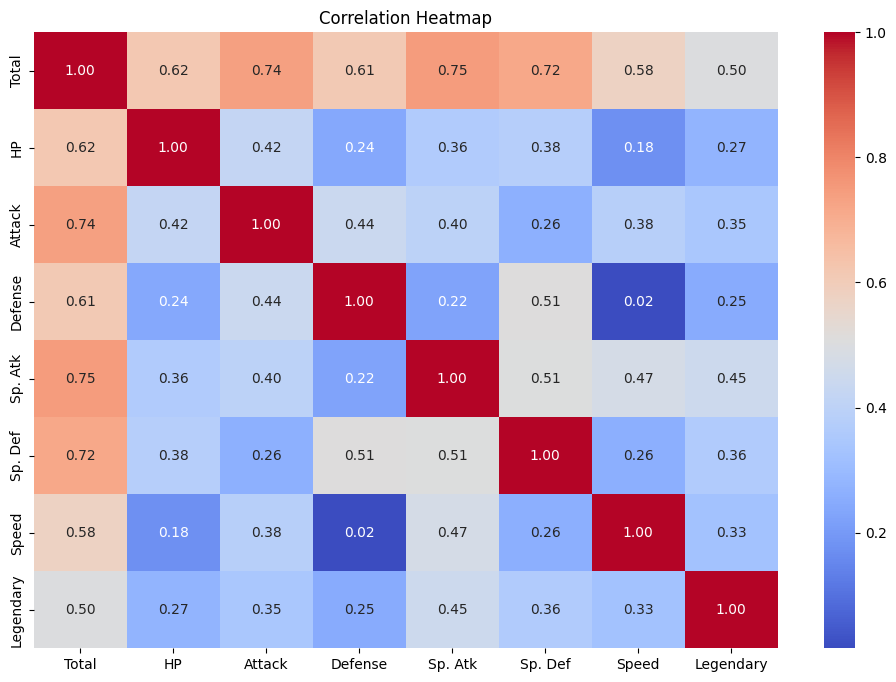

In [5]:
corr_matrix = pokemon_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


Based on the heatmap, the top two features that are most have the most correlation with Legendary is Sp. Atk and Total (Sum of all other stats)\
Let's now split the data to the features and target value


In [6]:
X = pokemon_df[["Sp. Atk", "Total"]]
y = pokemon_df["Legendary"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Make Predictions
y_pred = knn.predict(X_test)

# Evaluate the Model
print("Accuracy:", accuracy_score(y_test, y_pred))
labels = [False, True]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=labels))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.95625
Confusion Matrix:
 [[147   3]
 [  4   6]]
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.98      0.98       150
        True       0.67      0.60      0.63        10

    accuracy                           0.96       160
   macro avg       0.82      0.79      0.80       160
weighted avg       0.95      0.96      0.96       160



Testing the model on one entry only


In [7]:
single_entry = pd.DataFrame({'Sp. Atk': [50], 'Total': [200]})
single_entry = scaler.transform(single_entry)
single_pred = knn.predict(single_entry)
print(single_pred)

[False]


Let's try testing the model across a range of k values to determine an ideal k-value (one with the highest test accuracy_score)

In [37]:
def find_best_k(X_train, y_train, X_test, y_test, k_range):
    train_accuracies = []
    test_accuracies = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        
        # Evaluate on training data
        y_train_pred = knn.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on test data
        y_test_pred = knn.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_accuracies.append(test_accuracy)
        
        #print(f'k={k}, Train Accuracy={train_accuracy}, Test Accuracy={test_accuracy}')
    
    best_k = k_range[np.argmax(test_accuracies)]
    best_accuracy = max(test_accuracies)
    
    return best_k, best_accuracy, train_accuracies, test_accuracies

Best k: 1, Best Accuracy: 0.9625


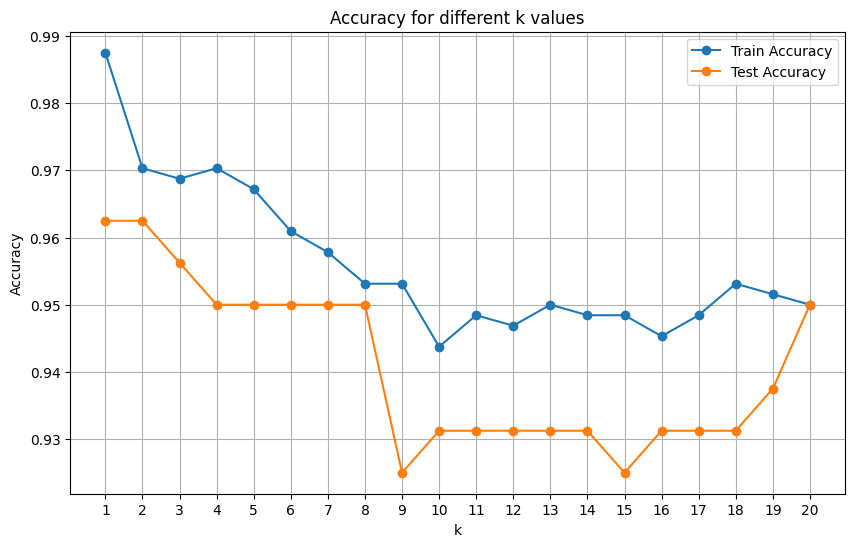

In [36]:
X = pokemon_df[["Sp. Atk", "Total"]]
y = pokemon_df["Legendary"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the range of k values to test
k_range = range(1, 21)

# Find the best k
best_k, best_accuracy, train_accuracies, test_accuracies = find_best_k(X_train, y_train, X_test, y_test, k_range)

print(f'Best k: {best_k}, Best Accuracy: {best_accuracy}')

# Plot the accuracy for each k value
plt.figure(figsize=(10, 6))
plt.plot(k_range, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(k_range, test_accuracies, marker='o', label='Test Accuracy')
plt.title('Accuracy for different k values')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend()
plt.grid()
plt.show()


Let's confirm the optimal k value. We can verify the optimal k by cross-validation to ensure it generalize well across different subsets of data

In [39]:
# Function to find the best k with cross-validation
def find_best_k_cv(X, y, k_range, cv=5):
    cv_accuracies = []
    
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        cv_scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        cv_accuracies.append(cv_scores.mean())
        #print(f'k={k}, CV Accuracy={cv_scores.mean()}')
    
    best_k = k_range[np.argmax(cv_accuracies)]
    best_cv_accuracy = max(cv_accuracies)
    
    return best_k, best_cv_accuracy, cv_accuracies

Best k (CV): 2, Best CV Accuracy: 0.9625


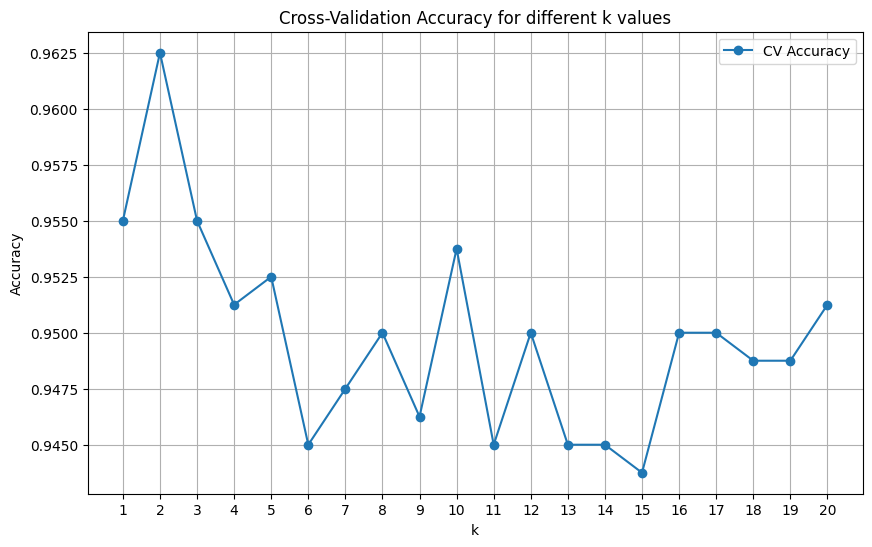

In [38]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Define the range of k values to test
k_range = range(1, 21)

# Find the best k with cross-validation
best_k_cv, best_cv_accuracy, cv_accuracies = find_best_k_cv(X, y, k_range)

print(f'Best k (CV): {best_k_cv}, Best CV Accuracy: {best_cv_accuracy}')

# Plot the cross-validation accuracy for each k value
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_accuracies, marker='o', label='CV Accuracy')
plt.title('Cross-Validation Accuracy for different k values')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.xticks(k_range)
plt.legend()
plt.grid()
plt.show()

Train the final KNN model with the best K

In [40]:
# Train the best model
best_knn = KNeighborsClassifier(n_neighbors=best_k_cv)
best_knn.fit(X_train, y_train)

# Make Predictions with the best model
y_pred = best_knn.predict(X_test)

# Evaluate the best model
print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
labels = [False, True]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred, labels=labels))
print("Classification Report:\n", classification_report(y_test, y_pred))

Final Model Accuracy: 0.9625
Confusion Matrix:
 [[149   1]
 [  5   5]]
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.99      0.98       150
        True       0.83      0.50      0.62        10

    accuracy                           0.96       160
   macro avg       0.90      0.75      0.80       160
weighted avg       0.96      0.96      0.96       160



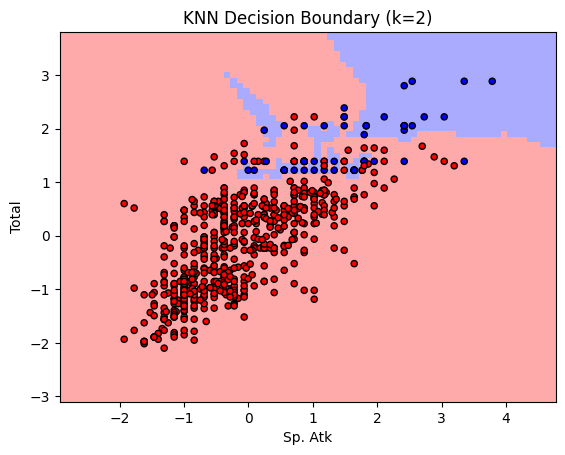

In [54]:
def plot_decision_boundary(X, y, k):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    # Train KNN model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)

    # Generate mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predict on mesh grid
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'KNN Decision Boundary (k={k})')
    plt.xlabel('Sp. Atk')
    plt.ylabel('Total')
    plt.show()

plot_decision_boundary(X_train, y_train, k=2)

- **True Negatives (TN): 149**
  - Non-legendary Pokémon correctly classified as non-legendary.
- **False Positives (FP): 1**
  - Non-legendary Pokémon incorrectly classified as legendary.
- **False Negatives (FN): 5**
  - Legendary Pokémon incorrectly classified as non-legendary.
- **True Positives (TP): 5**
  - Legendary Pokémon correctly classified as legendary.


1. **Precision**
   - **Formula**: Precision = TP / (TP + FP)
   - **False (Non-legendary Pokémon): 0.97**
     - When the model predicts a Pokémon is non-legendary, it is correct 97% of the time.
     - Calculation: 149 / (149 + 1) ≈ 0.99
   - **True (Legendary Pokémon): 0.83**
     - When the model predicts a Pokémon is legendary, it is correct 83% of the time.
     - Calculation: 5 / (5 + 1) ≈ 0.83

2. **Recall**
   - **Formula**: Recall = TP / (TP + FN)
   - **False (Non-legendary Pokémon): 0.99**
     - The model correctly identifies 99% of the actual non-legendary Pokémon.
     - Calculation: 149 / (149 + 1) ≈ 0.99
   - **True (Legendary Pokémon): 0.50**
     - The model correctly identifies only 50% of the actual legendary Pokémon.
     - Calculation: 5 / (5 + 5) = 0.50

3. **F1-Score**
   - **Formula**: F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
   - **False (Non-legendary Pokémon): 0.98**
     - Calculation: 2 * (0.97 * 0.99) / (0.97 + 0.99) ≈ 0.98
   - **True (Legendary Pokémon): 0.62**
     - Calculation: 2 * (0.83 * 0.50) / (0.83 + 0.50) ≈ 0.62

4. **Support**
   - **False: 150**
   - **True: 10**
     - Number of actual occurrences in the dataset for each class.

5. **Macro Average**
   - **Precision: 0.90**
     - Average of the precision values for each class.
   - **Recall: 0.75**
     - Average of the recall values for each class.
   - **F1-Score: 0.80**
     - Average of the F1-scores for each class.
     - Macro average considers each class equally, giving a balanced view across classes.

6. **Weighted Average**
   - **Precision: 0.96**
     - Weighted average of the precision values, taking into account the support for each class.
   - **Recall: 0.96**
     - Weighted average of the recall values, taking into account the support for each class.
   - **F1-Score: 0.96**
     - Weighted average of the F1-scores, taking into account the support for each class.
     - Weighted average provides an overall performance metric, considering the class imbalance.



## Conclusions

1. **High Overall Accuracy**:
   - The model achieves a high overall accuracy of 96.25%, indicating strong performance on the test set.

2. **Performance on Majority Class (Non-legendary Pokémon)**:
   - The model performs exceptionally well on the majority class, with high precision (0.97), recall (0.99), and F1-score (0.98).

3. **Performance on Minority Class (Legendary Pokémon)**:
   - The model struggles more with the minority class, with lower precision (0.83) and recall (0.50).
   - The lower recall indicates that the model misses a significant number of actual legendary Pokémon, which is common in imbalanced datasets.

4. **Class Imbalance Impact**:
   - The imbalance in the dataset (150 non-legendary vs. 10 legendary) affects the model's performance on the minority class.
   - Despite high overall accuracy, the lower recall for legendary Pokémon suggests room for improvement.

